In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

strategy.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 09:45:23,118 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:45:23,121 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:45:23,121 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 2. Explore

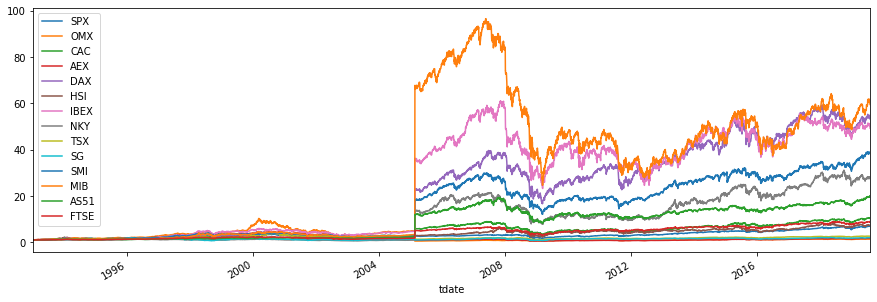

In [6]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

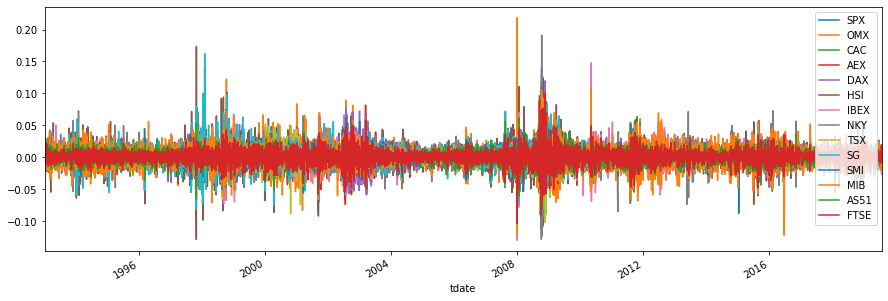

In [7]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [8]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [9]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [10]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [11]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [12]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [13]:
one_week = 5
one_month = 20

In [14]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [15]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [16]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

### MOVING AVERAGE

In [17]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [18]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [19]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [20]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692693	valid_1's binary_logloss: 0.692693
[20]	training's binary_logloss: 0.692297	valid_1's binary_logloss: 0.692297
[30]	training's binary_logloss: 0.691948	valid_1's binary_logloss: 0.691948
[40]	training's binary_logloss: 0.691638	valid_1's binary_logloss: 0.691638
[50]	training's binary_logloss: 0.691359	valid_1's binary_logloss: 0.691359
[60]	training's binary_logloss: 0.691099	valid_1's binary_logloss: 0.691099
[70]	training's binary_logloss: 0.690853	valid_1's binary_logloss: 0.690853
[80]	training's binary_logloss: 0.690615	valid_1's binary_logloss: 0.690615
[90]	training's binary_logloss: 0.690401	valid_1's binary_logloss: 0.690401
[100]	training's binary_logloss: 0.690198	valid_1's binary_logloss: 0.690198
[110]	training's binary_logloss: 0.69	valid_1's binary_logloss: 0.69
[120]	training's binary_logloss: 0.6898	valid_1's binary_logloss: 0.6898
[130]	training's binary_logloss: 0.

In [21]:
test_pred = model.predict(df_test_x.values)

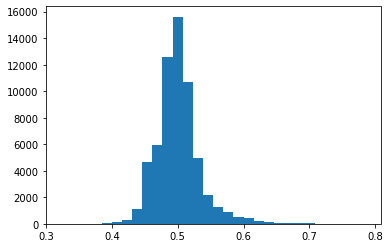

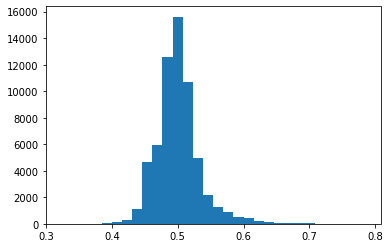

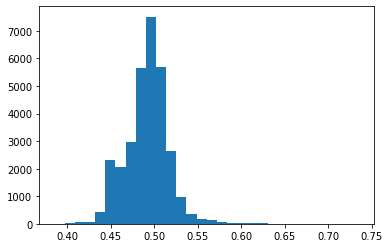

In [22]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [23]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [25]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

### MOMENTUM

### average return

In [26]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [27]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [28]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [29]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

In [30]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train2 = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val2 = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test2 = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train2['y']
df_train_x = df_train2[df_train2.columns[3:]]

df_val_y = df_val2['y']
df_val_x = df_val2[df_val2.columns[3:]]

df_test_y = df_test2['y']
df_test_x = df_test2[df_test2.columns[3:]]

In [31]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69283	valid_1's binary_logloss: 0.69283
[20]	training's binary_logloss: 0.692548	valid_1's binary_logloss: 0.692548
[30]	training's binary_logloss: 0.692294	valid_1's binary_logloss: 0.692294
[40]	training's binary_logloss: 0.692059	valid_1's binary_logloss: 0.692059
[50]	training's binary_logloss: 0.691841	valid_1's binary_logloss: 0.691841
[60]	training's binary_logloss: 0.69164	valid_1's binary_logloss: 0.69164
[70]	training's binary_logloss: 0.691446	valid_1's binary_logloss: 0.691446
[80]	training's binary_logloss: 0.691268	valid_1's binary_logloss: 0.691268
[90]	training's binary_logloss: 0.691095	valid_1's binary_logloss: 0.691095
[100]	training's binary_logloss: 0.690932	valid_1's binary_logloss: 0.690932
[110]	training's binary_logloss: 0.690774	valid_1's binary_logloss: 0.690774
[120]	training's binary_logloss: 0.690612	valid_1's binary_logloss: 0.690612
[130]	training's binary_log

In [32]:
test_pred = model.predict(df_test_x.values)

In [33]:
df_train2['y_pred'] = train_pred
df_test2['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 2차 학습

In [54]:
df_train_new = pd.concat([df_train['y_pred'], df_train2['y_pred']], axis=1)
df_test_new = pd.concat([df_test['y_pred'], df_test2['y_pred']], axis=1)

df_train_new.columns = ['mov', 'mom']
df_test_new.columns = ['mov', 'mom']

In [55]:
train_X = df_train_new
train_y = df_train_y

In [56]:
test_X = df_test_new
test_y = df_test_y

In [57]:
model = LogisticRegression()
model.fit(train_X, train_y)

train_y_pred_proba = model.predict_proba(train_X)[:,1]
test_y_pred_proba = model.predict_proba(test_X)[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [60]:
df_train['total_pred'] = train_y_pred_proba
df_test['total_pred'] = test_y_pred_proba

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='total_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='total_pred')

In [62]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [63]:
df_index_sub = df_index.loc['1994':]

In [64]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [65]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [66]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 09:51:31,323 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [67]:
tester = Tester(strategy)

In [68]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

In [69]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 09:51:32,324 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:51:32,324 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:51:32,325 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:51:46,162 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:51:46,163 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:51:47,748 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:51:47,755 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 09:51:48,840 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 09:51:48,843 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 09:51:48,844 - EPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 09:51:48,845 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 09:51:57,097 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31

### TRAIN

2019-10-31 09:51:58,423 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:51:58,424 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:51:58,431 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:51:58,439 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


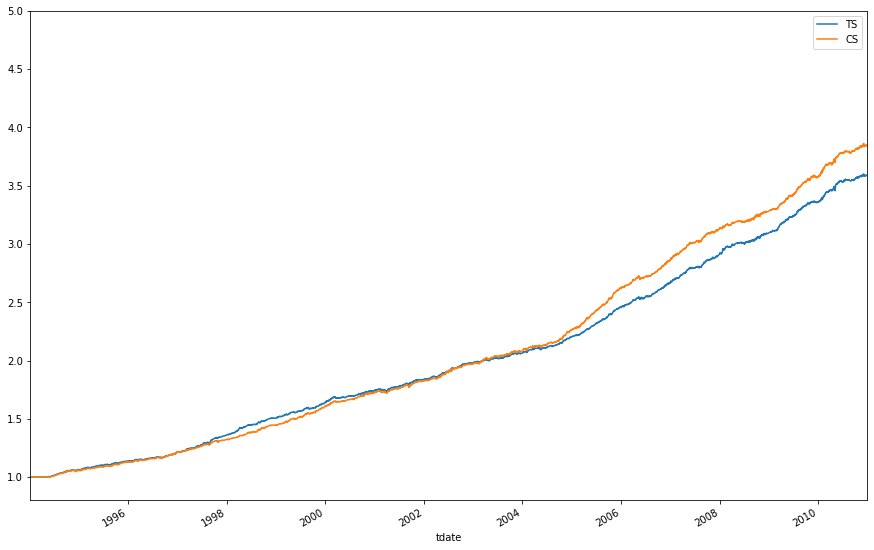

In [70]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:51:58,592 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:51:58,592 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:51:58,600 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:51:58,608 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


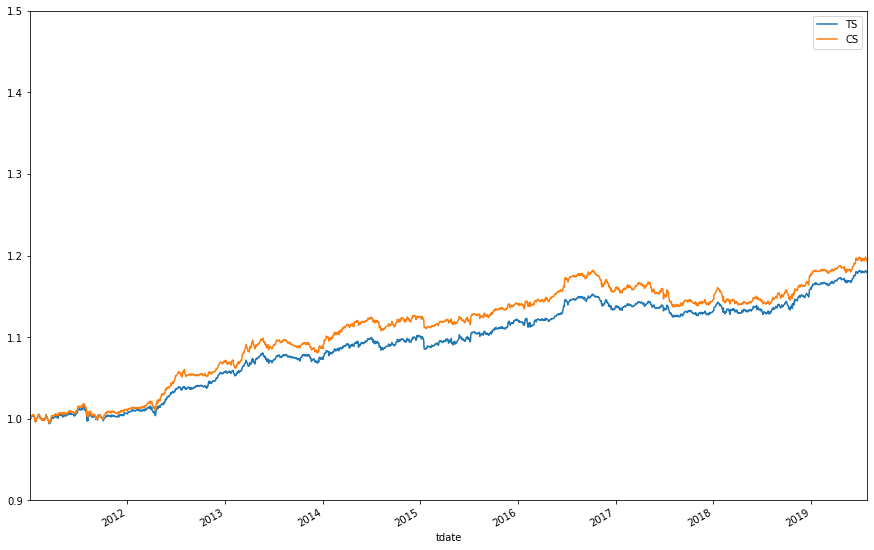

In [71]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))